# KNMI Drought Analysis: SPI & SPEI

In [1]:
# This is a good source, which actually tests the fit of empirical data in relation to different distributions!

# Default used in literature is Gamma, but here also Weibull, Exponential and log-normal were tested. 

# https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml

In [2]:
# Also give credits to: https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values 
# for a great Python-based MICE example that I could develop further on

In [2]:
import copy
import datetime
import numpy as np
import pandas as pd
import scipy.stats as scs

In [286]:
import knmi_meteo_ingest
import knmi_meteo_transform
import knmi_meteo_visualize

import knmi_spi_utils
import mice_imputation_utils

In [5]:
# Select station code
STN_CODE = 265

In [6]:
# Get station details for chosen code (sanity check)
stations_raw = knmi_meteo_ingest.knmi_load_meteo_stations()

# Show details of chosen station (should be non-empty)
stn = stations_raw[stations_raw["STN"] == STN_CODE].to_dict(orient="list")

# Assert error with message with valid options if station code not valid
valid_stns_str = ", ".join(str(x) for x in stations_raw["STN"])
err_msg = f"Invalid station code (integer) - valid options: {valid_stns_str}."

assert len(stn["NAME"]) > 0, err_msg

# Show details of chosen station
print(stn)

{'STN': [265], 'LON(east)': [5.274], 'LAT(north)': [52.13], 'ALT(m)': [13.9], 'NAME': ['Soesterberg']}


In [7]:
# Get daily precipiation data from KNMI web script service
df_rainlist_y = []

year_start = 1901
year_end = 2024

for year in range(year_start, year_end+1):
    df_rain_y = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=[STN_CODE],
                                                   meteo_params_list=["RH"],
                                                   start_date=datetime.date(year, 1, 1),
                                                   end_date=datetime.date(year, 12, 31),
                                                   mode="day")
    
    df_rainlist_y.append(df_rain_y)

In [8]:
# Concatenate each non-empty yearly series to full history
# Note: use 'ignore_index' to deduplicate indexes from yearly DataFrames
df_rain_raw = pd.concat([df for df in df_rainlist_y if not df.empty],
                        ignore_index=True)

In [9]:
# Show the result
df_rain_raw

,STN,YYYYMMDD,RH
0,265,19510901,NaN
1,265,19510902,NaN
2,265,19510903,NaN
3,265,19510904,NaN
4,265,19510905,NaN
...,...,...,...
20576,265,20081114,11.0
20577,265,20081115,21.0
20578,265,20081116,-1.0
20579,265,20081117,NaN


In [10]:
# Apply transformations to clean the raw dataset
df_rain = knmi_meteo_transform.transform_param_values(df_rain_raw)

In [11]:
# Cut off leading and trailing NaNs from history dataset
# In this way we get our actual historical start and end dates
min_idx = df_rain[["rain_sum"]].apply(pd.Series.first_valid_index).max()
max_idx = df_rain[["rain_sum"]].apply(pd.Series.last_valid_index).min()
df_rain = df_rain.loc[min_idx: max_idx, :]

In [12]:
# Show the result
df_rain

,station_code,date,rain_sum
8309,265,1974-06-01,0.300
8310,265,1974-06-02,0.300
8311,265,1974-06-03,7.400
8312,265,1974-06-04,0.000
8313,265,1974-06-05,0.000
...,...,...,...
20574,265,2008-11-12,0.200
20575,265,2008-11-13,0.000
20576,265,2008-11-14,1.100
20577,265,2008-11-15,2.100


In [13]:
# Now, re-index DataFrame so that it:
# 1. Always starts at first day of the first month found
first_date = df_rain["date"].iloc[0]
last_date = df_rain["date"].iloc[-1]
target_first_date = datetime.date(year=first_date.year, 
                                  month=first_date.month, 
                                  day=1)

# 2. Always ends on last day of last month found
target_last_date = (datetime.date(year=(last_date.year + (last_date.month // 12)),
                                  month=(last_date.month % 12) + 1,
                                  day=1) 
                                  - datetime.timedelta(days=1))

print(target_first_date, target_last_date)

1974-06-01 2008-11-30


In [14]:
# 3. Always has NaNs for missing indexes in the range
full_month_index = pd.date_range(target_first_date, target_last_date, freq="D")

# Set range of collected non-NaN dates as initial index
df_rain.index = pd.to_datetime(df_rain["date"])

# Reindex to full months
df_rain = df_rain.reindex(full_month_index)

In [15]:
# Show the result
df_rain

,station_code,date,rain_sum
1974-06-01,265.0,1974-06-01,0.3
1974-06-02,265.0,1974-06-02,0.3
1974-06-03,265.0,1974-06-03,7.4
1974-06-04,265.0,1974-06-04,0.0
1974-06-05,265.0,1974-06-05,0.0
...,...,...,...
2008-11-26,NaN,NaN,NaN
2008-11-27,NaN,NaN,NaN
2008-11-28,NaN,NaN,NaN
2008-11-29,NaN,NaN,NaN


In [16]:
# Remove station code and "incomplete" date column
drop_cols = ["date", "station_code"]
df_rain = df_rain.loc[:,~df_rain.columns.isin(drop_cols)]

# Rename full-month index to "date"
df_rain = df_rain.rename_axis(index="date")
df_rain

,rain_sum
date,
1974-06-01,0.3
1974-06-02,0.3
1974-06-03,7.4
1974-06-04,0.0
1974-06-05,0.0
...,...
2008-11-26,NaN
2008-11-27,NaN
2008-11-28,NaN


<Axes: title={'center': 'Soesterberg (265) - Daily precipitation [mm]'}, xlabel='date'>

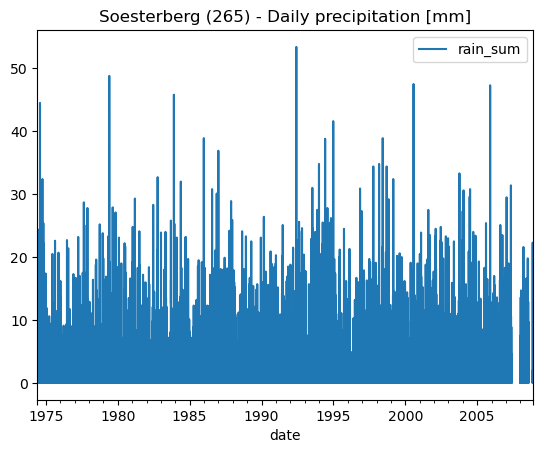

In [17]:
df_rain.plot(title=f"{stn["NAME"][0]} ({stn["STN"][0]}) - Daily precipitation [mm]")

In [18]:
# Convert full date into column for Grouper
if df_rain.index.name == "date":
    df_rain = df_rain.reset_index()

df_rain

,date,rain_sum
0,1974-06-01,0.3
1,1974-06-02,0.3
2,1974-06-03,7.4
3,1974-06-04,0.0
4,1974-06-05,0.0
...,...,...
12597,2008-11-26,NaN
12598,2008-11-27,NaN
12599,2008-11-28,NaN
12600,2008-11-29,NaN


In [19]:
agg_func = pd.NamedAgg(column=df_rain.columns[-1],
                       aggfunc=lambda x: 100.0 * np.mean(np.isnan(x)))
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_grouped = df_rain.groupby(grouper_obj).agg(result=agg_func)

In [20]:
df_rain_grouped["month"] = df_rain_grouped.index.month
df_rain_grouped["year"] = df_rain_grouped.index.year

df_rain_monthpivot = df_rain_grouped.pivot_table(index="year", columns="month", values="result")

In [21]:
with pd.option_context('display.max_rows', None,):
   print(df_rain_monthpivot.round(1))

month   1    2    3    4     5      6      7      8      9      10     11  \
year                                                                        
1974   NaN  NaN  NaN  NaN   NaN    0.0    0.0    0.0    0.0    0.0    0.0   
1975   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1976   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1977   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1978   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1979   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1980   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1981   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1982   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1983   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1984   0.0  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0    0.0   

In [22]:
# Find years to run imputation procedure for
df_rain_grouped[df_rain_grouped["result"] > 0]

,result,month,year
date,,,
2005-07-01,3.225806,7,2005
2007-05-01,29.032258,5,2007
2007-06-01,100.000000,6,2007
2007-07-01,100.000000,7,2007
2007-08-01,100.000000,8,2007
2007-09-01,100.000000,9,2007
2007-10-01,100.000000,10,2007
2007-11-01,100.000000,11,2007
2007-12-01,83.870968,12,2007


In [23]:
# NOTE: Method below will not work (well) if all years in your dataset have almost 100% missing data;
# you should use multiple years of data in those cases, but logic for this edge scenario is not written here; implement yourself if needed!
# If you have a relatively long history of data anyway, you can also consider dropping that year outright

In [24]:
# Find unique years to run imputation for
years_to_impute = df_rain_grouped[df_rain_grouped["result"] > 0]["year"].tolist()
years_to_impute = list(set(years_to_impute))
years_to_impute.sort()

print(years_to_impute)

[2005, 2007, 2008]


In [25]:
try_impute = False
df_implist_y = []

if len(years_to_impute) > 0:
    # Get rain data of all stations for years to impute for
    try_impute = True

    for year in years_to_impute:
        df_imp_y = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                      meteo_params_list=["RH"],
                                                      start_date=datetime.date(year, 1, 1),
                                                      end_date=datetime.date(year, 12, 31),
                                                      mode="day")
    
        df_implist_y.append(df_imp_y)

In [26]:
# Concatenate each non-empty yearly series to full history
# Note: use 'ignore_index' to deduplicate indexes from yearly DataFrames
if try_impute:
    if len(df_implist_y) > 0:
        df_imp_raw = pd.concat([df for df in df_implist_y if not df.empty],
                                ignore_index=True)

In [27]:
if try_impute:
    # Apply transformations to clean the raw dataset
    df_imp = knmi_meteo_transform.transform_param_values(df_imp_raw)

    # Show the result
    print(df_imp)

       station_code        date  rain_sum
0               209  2005-01-01       NaN
1               209  2005-01-02       NaN
2               209  2005-01-03       NaN
3               209  2005-01-04       NaN
4               209  2005-01-05       NaN
...             ...         ...       ...
52973           391  2008-12-27       0.0
52974           391  2008-12-28       0.0
52975           391  2008-12-29       0.0
52976           391  2008-12-30       0.0
52977           391  2008-12-31       0.0

[52978 rows x 3 columns]


In [28]:
if try_impute:
    # Pivot data with 'date' as index, 'stn_code' as cols
    df_imp_pivot = (df_imp.pivot(index="date",
                                 columns="station_code"))

    # Flatten pivot table to single index
    df_imp_pivot.columns = (df_imp_pivot.columns
                            .get_level_values(1))
    
    # Show the result
    print(df_imp_pivot)

station_code  209  210  225    235    240  242  248  249  251  257  ...  343  \
date                                                                ...        
2005-01-01    NaN  1.5  NaN  0.600  2.100  NaN  NaN  1.4  4.0  0.7  ...  NaN   
2005-01-02    NaN  0.1  NaN  0.025  0.000  NaN  NaN  0.0  0.4  0.0  ...  NaN   
2005-01-03    NaN  0.0  NaN  0.000  0.000  NaN  NaN  0.0  1.6  0.0  ...  NaN   
2005-01-04    NaN  0.9  NaN  3.300  1.500  NaN  NaN  1.5  0.4  1.1  ...  NaN   
2005-01-05    NaN  2.4  NaN  4.400  3.300  NaN  NaN  4.4  3.3  3.9  ...  NaN   
...           ...  ...  ...    ...    ...  ...  ...  ...  ...  ...  ...  ...   
2008-12-27    NaN  0.0  NaN  0.000  0.000  NaN  NaN  0.0  0.0  0.0  ...  NaN   
2008-12-28    NaN  0.0  NaN  0.000  0.000  NaN  NaN  0.0  0.0  0.0  ...  NaN   
2008-12-29    NaN  0.0  NaN  0.000  0.000  NaN  NaN  0.0  0.0  0.0  ...  NaN   
2008-12-30    NaN  0.0  NaN  0.000  0.000  NaN  NaN  0.0  0.0  0.0  ...  NaN   
2008-12-31    NaN  0.0  NaN  0.000  0.02

In [29]:
# Sort all stations on correlation with target station
# The station itself will have a value of 1 (by definition)
if try_impute:
    corr_scores = (df_imp_pivot
                   .corrwith(df_imp_pivot[STN_CODE])
                   .sort_values(ascending=False))
    print(corr_scores)

station_code
265    1.000000
260    0.933660
356    0.845402
275    0.841238
240    0.792410
210    0.790389
257    0.775355
375    0.775257
269    0.772231
370    0.759260
330    0.753599
348    0.751736
283    0.742983
344    0.741021
249    0.730716
290    0.727423
278    0.709835
377    0.669297
273    0.661622
235    0.641102
267    0.640624
350    0.638358
323    0.614019
279    0.602763
391    0.588620
319    0.580390
286    0.571121
280    0.567938
270    0.551835
251    0.534557
380    0.518981
277    0.515362
310    0.454668
209         NaN
225         NaN
242         NaN
248         NaN
258         NaN
285         NaN
308         NaN
311         NaN
312         NaN
313         NaN
315         NaN
316         NaN
324         NaN
331         NaN
340         NaN
343         NaN
dtype: float64


In [30]:
run_impute = False

if try_impute:
    # Find up to N best-correlating stations for imputation years
    # Note: less stations will be used in case of empty results
    nr_impute_stns = 5

    # Drop NaNs from the correlation scores
    corr_scores = corr_scores[~corr_scores.isna()]

    # Get maximum index (minimum of N and non-NaN corr elements)
    max_corr_idx = min(1 + nr_impute_stns, len(corr_scores))
    impute_stn_codes = corr_scores[1 : max_corr_idx].index.tolist()

    # Print warning message in case of all-NaN correlations
    warn_msg = ("No matching stations found for MICE imputation; use "
               "another method or drop missing data instead of imputing.")
    if len(impute_stn_codes) == 0:
        print(warn_msg)
        run_impute = False
    else:
        run_impute = True

    # If all OK, print external station codes to use for imputation
    print(impute_stn_codes)

[260, 356, 275, 240, 210]


In [31]:
print(run_impute)

True


In [32]:
if run_impute:
    # Define colums to keep for imputation calculation
    keep_cols = [STN_CODE] + impute_stn_codes

    # Apply column filter
    df_imp_sel = df_imp_pivot.loc[:, df_imp_pivot.columns.isin(keep_cols)]

    # Ensure that our target impute column is always the first
    df_imp_sel = df_imp_sel[[STN_CODE] + impute_stn_codes]

    # Get maximum value from imp. dataset; no imp. value should be larger
    max_imp_val = np.nanmax(df_imp_sel.values)

    # Show the result (table with data to use for imputation)
    print(df_imp_sel)

station_code    265    260  356  275    240  210
date                                            
2005-01-01    1.600  1.300  3.1  2.6  2.100  1.5
2005-01-02    0.025  0.025  0.0  0.1  0.000  0.1
2005-01-03    0.000  0.000  0.0  0.0  0.000  0.0
2005-01-04    1.100  1.600  1.2  1.4  1.500  0.9
2005-01-05    3.400  3.200  1.8  2.8  3.300  2.4
...             ...    ...  ...  ...    ...  ...
2008-12-27      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-28      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-29      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-30      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-31      NaN  0.025  0.0  0.0  0.025  0.0

[1096 rows x 6 columns]


In [33]:
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, BayesianRidge)
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

# Note: IterativeImputer is still experimental; import as such
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [34]:
if run_impute:
    # Set random seed value at 42 for result reproducibility
    r_seed = 42
    np.random.seed(r_seed)
 
    full_data = df_imp_sel.dropna(subset=[STN_CODE])
    incomplete_data = full_data.copy()

    # Introduce missingness in target column (here: 25% of values missing at random)
    missing_mask = np.random.rand(incomplete_data.shape[0]) < 0.25
    incomplete_data.loc[missing_mask, STN_CODE] = np.nan

    # Test values are only present in the "full_data" overview
    test_vals = full_data.loc[missing_mask, STN_CODE].to_numpy()

    # Set base imputer
    base_imputer = IterativeImputer(max_iter=30, tol=1e-6, min_value=0,
                                    max_value=max_imp_val, random_state=r_seed,
                                    imputation_order="roman")

    # Set model scoring emphasis (RMSE versus R^2)
    alpha = 0.5

    # Define the models and their parameter grids
    models_and_params = {
        "LinearRegression":
            (LinearRegression(), {}),
        "Ridge": (
            Ridge(),
            {
            "alpha": [0.1, 1.0, 10.0]
            }
        ),
        "Lasso": (
            Lasso(),
            {
            "alpha": [0.001, 0.01, 0.1, 1.0, 10.0]
            }
        ),
        "Random Forest": (
            RandomForestRegressor(random_state=r_seed),
            {
            "n_estimators": [10, 20, 50, 100],
            "max_depth": [3, 5, 7, 10]
            }
        ),
        "GradientBoostingRegressor": (
            GradientBoostingRegressor(random_state=r_seed),
            {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7, 10]
            },
        ),
        "BayesianRidge": (
            BayesianRidge(),
            {
            "alpha_1": [1e-6, 1e-5],
            "alpha_2": [1e-6, 1e-5],
            "lambda_1": [1e-6, 1e-5],
            "lambda_2": [1e-6, 1e-5],
            },
        ),
        "KNeighborsRegressor": (
            KNeighborsRegressor(),
            {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            },
        ),
    }

    # Initialize variables to track the best model and its performance
    best_model_name = None
    best_params = None
    best_score = float("inf")
    best_imputer = None

    # Loop through each model and parameter grid
    for model_name, (model, param_grid) in models_and_params.items():
        print(f"Testing model: {model_name}")
    
        # Iterate through all parameter combinations
        for params in ParameterGrid(param_grid):
            # Create a new estimator with the current parameters
            estimator = model.set_params(**params)
        
            # Set up the imputer with this estimator
            imputer = base_imputer.set_params(estimator=estimator)
        
            # Fit the imputer on the incomplete data
            imputed_data = imputer.fit_transform(incomplete_data)
        
            # Calculate the MSE and R^2 for the imputed values
            mse = mean_squared_error(
                test_vals,
                imputed_data[missing_mask, 0].round(3))

            r2 = r2_score(
                test_vals,  
                imputed_data[missing_mask, 0].round(3))
        
            # Combine the RMSE and R^2 into a single score
            score = alpha * np.sqrt(mse) - (1 - alpha) * (1 - r2)
        
            # print(f"  Params: {params}, MSE: {mse:.4f}, R^2: {r2:.4f}, score: {score:.4f}")
        
            # Update the best model if this is the best scoring one
            if score < best_score:
                best_score = score
                best_params = params
                best_model_name = model_name
                best_imputer = copy.deepcopy(imputer)

    # Print the best model and parameters
    print("\nBest Model and Parameters:")
    print(f"  Model: {best_model_name}")
    print(f"  Parameters: {best_params}")
    print(f"  Best score: {best_score:.4f}")

    # Use the best imputer for further imputation if needed
    final_imputed_data = best_imputer.transform(incomplete_data)

    # Calculate (R)MSE and R^2 for the best model
    final_mse = mean_squared_error(
        test_vals, # True values
        final_imputed_data[missing_mask, 0]) # Imputed values
    final_rmse = np.sqrt(final_mse)

    final_r2 = r2_score(
        test_vals,  # True values
        final_imputed_data[missing_mask, 0],  # Imputed values
    )

    print(f"  Imputation MSE: {final_mse:.4f}")
    print(f"  Imputation RMSE: {final_rmse:.4f}")
    print(f"  Imputation R^2: {final_r2:.4f}")

Testing model: LinearRegression
Testing model: Ridge
Testing model: Lasso
Testing model: Random Forest
Testing model: GradientBoostingRegressor
Testing model: BayesianRidge
Testing model: KNeighborsRegressor

Best Model and Parameters:
  Model: Random Forest
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Best score: 0.6373
  Imputation MSE: 1.8627
  Imputation RMSE: 1.3648
  Imputation R^2: 0.9099


In [35]:
if run_impute:
    (best_imputer, best_res, df_imp_filled_test) = mice_imputation_utils.fit_best_df_imputer_on_targetcol(df_imp_sel, STN_CODE)

    print(df_imp_filled_test)

Testing 'LinearRegression' model(s):
  Params: {}, MSE: 2.4015, R^2: 0.8838, score: 0.7168
Testing 'Ridge' model(s):
  Params: {'alpha': 0.1}, MSE: 2.4015, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 1.0}, MSE: 2.4013, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 10.0}, MSE: 2.3991, R^2: 0.8839, score: 0.7164
Testing 'Lasso' model(s):
  Params: {'alpha': 0.001}, MSE: 2.4013, R^2: 0.8838, score: 0.7167
  Params: {'alpha': 0.01}, MSE: 2.3984, R^2: 0.8840, score: 0.7163
  Params: {'alpha': 0.1}, MSE: 2.3792, R^2: 0.8849, score: 0.7137
  Params: {'alpha': 1.0}, MSE: 2.4937, R^2: 0.8794, score: 0.7292
  Params: {'alpha': 10.0}, MSE: 7.4999, R^2: 0.6372, score: 1.1879
Testing 'Random Forest' model(s):
  Params: {'max_depth': 3, 'n_estimators': 10}, MSE: 2.1170, R^2: 0.8976, score: 0.6763
  Params: {'max_depth': 3, 'n_estimators': 20}, MSE: 2.1550, R^2: 0.8957, score: 0.6819
  Params: {'max_depth': 3, 'n_estimators': 50}, MSE: 2.3326, R^2: 0.8871, score: 0.7072
  Params: {'max_depth': 3,

In [36]:
if run_impute:
    print(df_imp_sel)

station_code    265    260  356  275    240  210
date                                            
2005-01-01    1.600  1.300  3.1  2.6  2.100  1.5
2005-01-02    0.025  0.025  0.0  0.1  0.000  0.1
2005-01-03    0.000  0.000  0.0  0.0  0.000  0.0
2005-01-04    1.100  1.600  1.2  1.4  1.500  0.9
2005-01-05    3.400  3.200  1.8  2.8  3.300  2.4
...             ...    ...  ...  ...    ...  ...
2008-12-27      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-28      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-29      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-30      NaN  0.000  0.0  0.0  0.000  0.0
2008-12-31      NaN  0.025  0.0  0.0  0.025  0.0

[1096 rows x 6 columns]


In [37]:
if run_impute:
    # Now fit and run the best imputer on the FULL to-impute dataset
    df_imputed = pd.DataFrame(data=best_imputer.fit_transform(df_imp_sel),
                              columns=df_imp_sel.columns,
                              index=df_imp_sel.index)

    # Only keep imputed values that were missing in dataset
    df_imputed["init_val"] = df_imp_sel[STN_CODE]
    df_imputed = df_imputed[df_imputed["init_val"].isna()]
    df_imputed = df_imputed.loc[:, [STN_CODE]]

    # Convert index type to DateTime
    df_imputed.index = pd.to_datetime(df_imputed.index)

    # Rename columns and reset 'date' col; show the result
    df_imputed = (df_imputed
                  .rename(columns={STN_CODE: "rain_sum_imputed"})
                  .reset_index())

    print(df_imputed)

station_code       date  rain_sum_imputed
0            2005-07-31         16.091713
1            2007-05-23          0.008186
2            2007-05-24          0.008186
3            2007-05-25          0.008186
4            2007-05-26          1.582548
..                  ...               ...
358          2008-12-27          0.008186
359          2008-12-28          0.008186
360          2008-12-29          0.008186
361          2008-12-30          0.008186
362          2008-12-31          0.097773

[363 rows x 2 columns]


In [38]:
if run_impute:
    # Merge imputed data with measured data if imputation was run
    df_rain_all = df_rain.merge(df_imputed, how="left", on="date").round(2)
else:
    # If no missing data were found, only add all-NaN imputation column
    df_rain_all = df_rain.copy()
    df_rain_all["rain_sum_imputed"] = np.nan

df_rain_all

,date,rain_sum,rain_sum_imputed
0,1974-06-01,0.3,NaN
1,1974-06-02,0.3,NaN
2,1974-06-03,7.4,NaN
3,1974-06-04,0.0,NaN
4,1974-06-05,0.0,NaN
...,...,...,...
12597,2008-11-26,NaN,0.69
12598,2008-11-27,NaN,0.10
12599,2008-11-28,NaN,0.01
12600,2008-11-29,NaN,0.28


In [39]:
print(f"Values in original dataset: {df_rain_all["rain_sum"].notna().sum()}"
      f"\nValues in imputed dataset: {df_rain_all["rain_sum_imputed"].notna().sum()}")

Values in original dataset: 12270
Values in imputed dataset: 332


In [40]:
df_rain_all

,date,rain_sum,rain_sum_imputed
0,1974-06-01,0.3,NaN
1,1974-06-02,0.3,NaN
2,1974-06-03,7.4,NaN
3,1974-06-04,0.0,NaN
4,1974-06-05,0.0,NaN
...,...,...,...
12597,2008-11-26,NaN,0.69
12598,2008-11-27,NaN,0.10
12599,2008-11-28,NaN,0.01
12600,2008-11-29,NaN,0.28


<Axes: xlabel='date'>

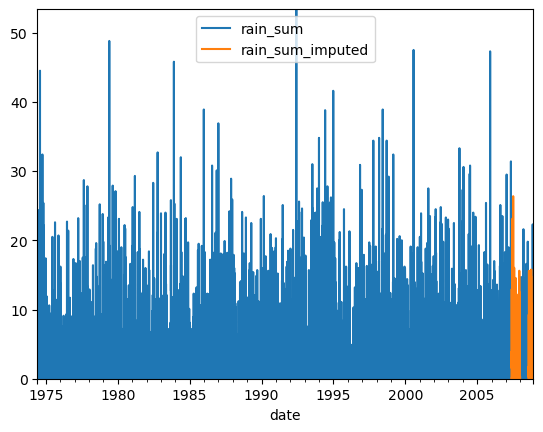

In [41]:
y_max = np.nanmax(df_rain_all.set_index("date").values)
df_rain_all.set_index("date").plot(ylim=(0, y_max))

<Axes: ylabel='Frequency'>

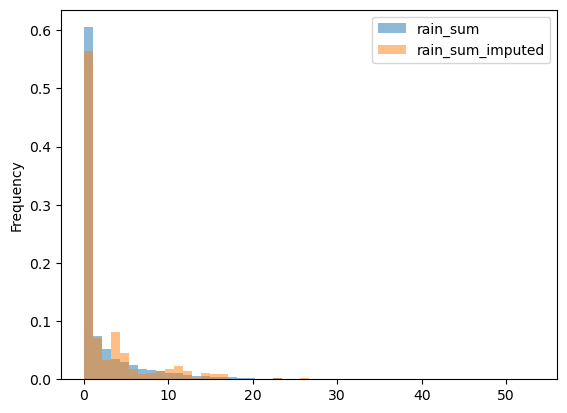

In [42]:
df_rain_all.set_index("date").plot(kind="hist", bins=50, density=True, alpha=0.5)

<Axes: ylabel='Frequency'>

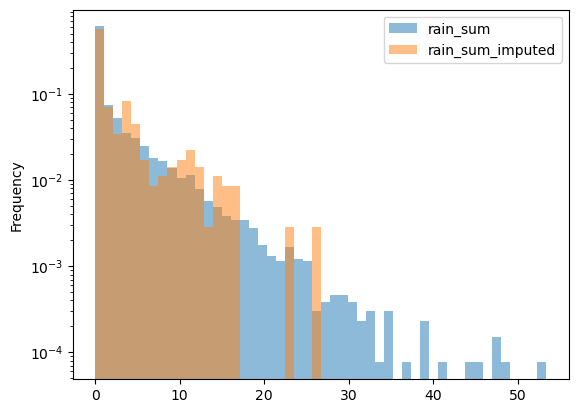

In [43]:
df_rain_all.set_index("date").plot(kind="hist", density=True, 
                                   alpha=0.5, logy=True, bins=50)

In [44]:
# Now, continue with the SPI analysis

In [45]:
# Keep track of fact whether data was imputed or not
df_rain_all["is_imputed"] = (df_rain_all["rain_sum"].isna() 
                             & ~df_rain_all["rain_sum_imputed"].isna())

# Create a fully-filled column with mixed real and imp. values
# Start by filling the column with the originally measured data
df_rain_all["rain_sum_all"] = df_rain_all["rain_sum"].copy()

# Fill the "_all" column with imputed data wherever applicable
filter_idxs = df_rain_all[df_rain_all["rain_sum_all"].isna()].index
df_rain_all.loc[filter_idxs, "rain_sum_all"] = df_rain_all["rain_sum_imputed"].copy()

df_rain_all

,date,rain_sum,rain_sum_imputed,is_imputed,rain_sum_all
0,1974-06-01,0.3,NaN,False,0.30
1,1974-06-02,0.3,NaN,False,0.30
2,1974-06-03,7.4,NaN,False,7.40
3,1974-06-04,0.0,NaN,False,0.00
4,1974-06-05,0.0,NaN,False,0.00
...,...,...,...,...,...
12597,2008-11-26,NaN,0.69,True,0.69
12598,2008-11-27,NaN,0.10,True,0.10
12599,2008-11-28,NaN,0.01,True,0.01
12600,2008-11-29,NaN,0.28,True,0.28


In [46]:
# Only keep parameter column and imputation label (yes/no)
keep_cols = ["date", "rain_sum_all", "is_imputed"]
df_rain_sel = df_rain_all[keep_cols]

df_rain_sel

,date,rain_sum_all,is_imputed
0,1974-06-01,0.30,False
1,1974-06-02,0.30,False
2,1974-06-03,7.40,False
3,1974-06-04,0.00,False
4,1974-06-05,0.00,False
...,...,...,...
12597,2008-11-26,0.69,True
12598,2008-11-27,0.10,True
12599,2008-11-28,0.01,True
12600,2008-11-29,0.28,True


In [47]:
# Set aggregation rules; any aggregate that still has any NaN(s) 
# in its value is summed to NaN as a whole (prevent dist-fit errors)
lambda_sum_func = lambda x: np.nan if x.isnull().any() else x.sum()
agg_dict = {"rain_sum_all": lambda_sum_func,
            "is_imputed": "mean"}

In [48]:
# Aggregate dataset to months
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_m_gr = (df_rain_sel
                .groupby(grouper_obj)
                .agg(agg_dict))

df_rain_m_gr

,rain_sum_all,is_imputed
date,,
1974-06-01,55.80,0.000000
1974-07-01,84.02,0.000000
1974-08-01,94.68,0.000000
1974-09-01,124.34,0.000000
1974-10-01,142.84,0.000000
...,...,...
2008-07-01,105.79,0.096774
2008-08-01,99.16,1.000000
2008-09-01,63.53,1.000000


In [49]:
# Test: use rolling window for N months
N = 3
df_rain_sums = df_rain_m_gr.rolling(window=N).agg(agg_dict)

df_rain_sums

,rain_sum_all,is_imputed
date,,
1974-06-01,NaN,NaN
1974-07-01,NaN,NaN
1974-08-01,234.50,0.000000
1974-09-01,303.04,0.000000
1974-10-01,361.86,0.000000
...,...,...
2008-07-01,193.71,0.032258
2008-08-01,244.17,0.365591
2008-09-01,268.48,0.698925


In [50]:
# TODO: Make plot of values; use score of 'is_imputed' as color!
# (Can be done using a scatter plot)

In [51]:
# TODO: Change to import from module!
# Time for fitting a distribution! 

# We will need (just as in: https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml):
# 1. Gamma distribution function (note: totals should be nonzero!)
# 2. Exponential distribution function
# 3. Lognormal distribution function
# 4. Weibull distribution function
dist_names = ["gamma", "expon", "lognorm", "weibull_min"]

df_distr = pd.DataFrame()
df_distr["rain_sum"] = df_rain_sums["rain_sum_all"].copy()

# Just to make sure: set any total of 0 mm to 0.1 mm (to avoid zero-issues with gamma)
# Note: in arid regions, this may not suffice for a good fit
filter_idxs = df_distr[df_distr["rain_sum"] == 0.0].index
df_distr[df_distr.loc[filter_idxs, "rain_sum"]] = 0.1

# Get PDFs and CDFs for each best-fit distribution (using Max. Likelihood Est.)
for dist_name in dist_names:
    dist = getattr(scs, dist_name)

    params = dist.fit(df_distr["rain_sum"].dropna(), method="mle", loc=0)
    
    df_distr[dist_name + "_cdf"] = dist.cdf(df_distr["rain_sum"], *params)
    df_distr[dist_name + "_pdf"] = dist.pdf(df_distr["rain_sum"], *params)

In [52]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf
date,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558
...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722


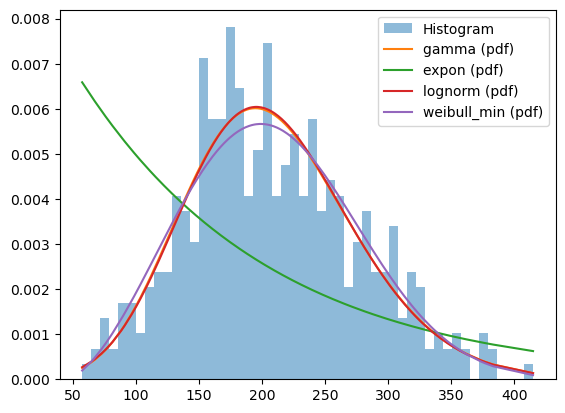

In [53]:
import matplotlib.pyplot as plt

df_d_plot = df_distr.sort_values(by="rain_sum")

plt.hist(df_d_plot["rain_sum"], bins=50, density=True, alpha=0.5, label='Histogram')
x = np.linspace(df_d_plot["rain_sum"].min(), df_distr["rain_sum"].max(), 100)

for distr in dist_names:
    plt.plot(df_d_plot["rain_sum"], df_d_plot[distr + "_pdf"], label=distr + ' (pdf)')

plt.legend()

In [54]:
ecdf_res = scs.ecdf(df_rain_sums["rain_sum_all"].dropna())
df_distr["ecdf"] = ecdf_res.cdf.evaluate(df_rain_sums["rain_sum_all"])
df_distr.loc[df_distr["rain_sum"].isna(), "ecdf"] = np.nan

df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf
date,,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071,0.657767
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215,0.900485
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558,0.985437
...,...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650,0.451456
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738,0.713592
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722,0.803398


<Axes: xlabel='rain_sum'>

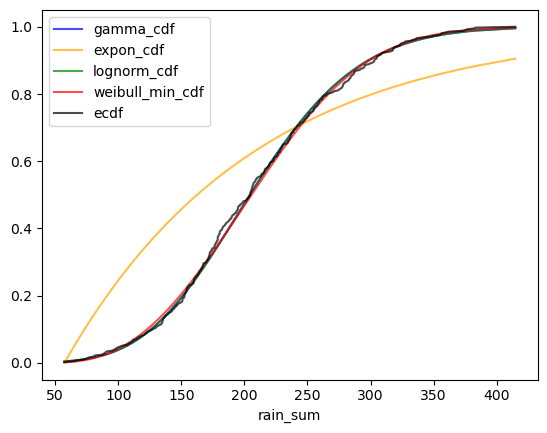

In [55]:
colors = ["blue", "orange", "green", "red", "black"]
df_distr[["rain_sum"] + [d + "_cdf" for d in dist_names] + ["ecdf"]].sort_values(
    by="rain_sum").plot(x="rain_sum", alpha=0.7, color=colors)

In [56]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf
date,,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071,0.657767
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215,0.900485
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558,0.985437
...,...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650,0.451456
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738,0.713592
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722,0.803398


In [57]:
# Calculate the squared differences (L2-norm) between the ECDF and each distribution's CDF
# In this way we can intuitively choose the best-matching one
distances = {}
for dist_name in dist_names:
    # Squared differences (L2-norm)
    squared_diff = (df_distr["ecdf"] - df_distr[dist_name + "_cdf"]) ** 2
    # Sum of squared differences (L2-norm distance)
    distances[dist_name] = squared_diff.sum()

best_fit = min(distances, key=distances.get)

print(distances)
print(best_fit)

{'gamma': 0.05299303883824423, 'expon': 10.802755918847097, 'lognorm': 0.05974459648595951, 'weibull_min': 0.07005827259025206}
gamma


In [58]:
# Apply inverse normal distribution to best-fit CDF
norm_ppf = scs.norm.ppf(df_distr[best_fit + "_cdf"])
norm_ppf[np.isinf(norm_ppf)] = np.nan

df_distr["spi_3"] = norm_ppf.copy()

df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf,spi_3
date,,,,,,,,,,,
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,234.50,0.668963,0.005085,0.688837,0.002050,0.668972,0.005121,0.656341,0.005071,0.657767,0.437050
1974-09-01,303.04,0.910026,0.002019,0.801903,0.001305,0.910805,0.002010,0.909131,0.002215,0.900485,1.340915
1974-10-01,361.86,0.979359,0.000567,0.865544,0.000886,0.979517,0.000559,0.983595,0.000558,0.985437,2.040694
...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,193.71,0.436696,0.006013,0.592903,0.002682,0.435160,0.006040,0.432538,0.005650,0.451456,-0.159351
2008-08-01,244.17,0.716140,0.004665,0.708043,0.001923,0.716470,0.004695,0.703813,0.004738,0.713592,0.571412
2008-09-01,268.48,0.815603,0.003509,0.751250,0.001639,0.816417,0.003519,0.807026,0.003722,0.803398,0.898733


<Axes: xlabel='date'>

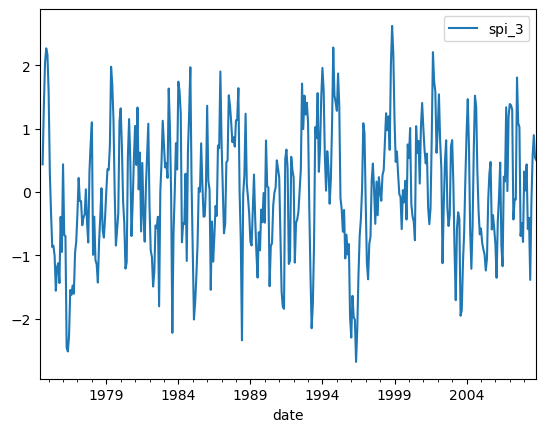

In [59]:
df_distr.reset_index().plot(x="date", y="spi_3")

In [60]:
# Collect all SPI series for one location
df_rain_data = knmi_spi_utils.simplify_dataset(df_rain_all, "rain_sum")
df_m_spi = knmi_spi_utils.calculate_nmonth_spi(df_rain_data, "rain_sum")
 
df_m_spi

,rain_sum,is_imputed,spi_1,spi_3,spi_6,spi_9,spi_12,spi_24
date,,,,,,,,
1974-06-01,55.80,0.000000,-0.256245,NaN,NaN,NaN,NaN,NaN
1974-07-01,84.02,0.000000,0.458244,NaN,NaN,NaN,NaN,NaN
1974-08-01,94.68,0.000000,0.706292,0.437050,NaN,NaN,NaN,NaN
1974-09-01,124.34,0.000000,1.359695,1.340915,NaN,NaN,NaN,NaN
1974-10-01,142.84,0.000000,1.748429,2.040694,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.096774,0.956454,-0.159351,-0.530762,-0.294024,-0.557647,0.929963
2008-08-01,99.16,1.000000,0.808084,0.571412,0.089484,0.026817,-0.206370,0.556421
2008-09-01,63.53,1.000000,-0.049587,0.898733,-0.240566,-0.008622,-0.355838,0.793850


<Axes: xlabel='date'>

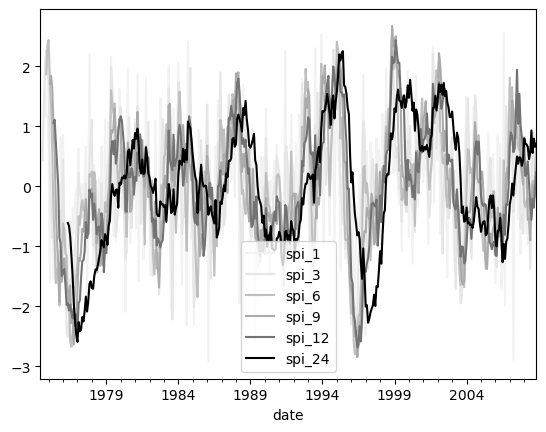

In [61]:
colors = ["0.95", "0.9", "0.75", "0.67", "0.45", "0"]
df_m_spi.loc[:, df_m_spi.columns.str.contains("spi")].plot(color=colors)

Quote from WMO Report:
> A drought event occurs any time the SPI is continuously negative and reaches an intensity of -1.0 or less. The event ends when the SPI becomes positive. Each drought event, therefore, has a duration defined by its beginning and end, and an intensity for each month that the event continues. The positive sum of the SPI for all the months within a drought event can be termed the drought’s “magnitude”.


In [62]:
df_m_spi

,rain_sum,is_imputed,spi_1,spi_3,spi_6,spi_9,spi_12,spi_24
date,,,,,,,,
1974-06-01,55.80,0.000000,-0.256245,NaN,NaN,NaN,NaN,NaN
1974-07-01,84.02,0.000000,0.458244,NaN,NaN,NaN,NaN,NaN
1974-08-01,94.68,0.000000,0.706292,0.437050,NaN,NaN,NaN,NaN
1974-09-01,124.34,0.000000,1.359695,1.340915,NaN,NaN,NaN,NaN
1974-10-01,142.84,0.000000,1.748429,2.040694,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,105.79,0.096774,0.956454,-0.159351,-0.530762,-0.294024,-0.557647,0.929963
2008-08-01,99.16,1.000000,0.808084,0.571412,0.089484,0.026817,-0.206370,0.556421
2008-09-01,63.53,1.000000,-0.049587,0.898733,-0.240566,-0.008622,-0.355838,0.793850


In [63]:
spi_timeframe_m = 12
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spi, f"spi_{spi_timeframe_m}", "drought"))
events_df.sort_values(f"drought_spi_{spi_timeframe_m}_magnitude", ascending=False)

,drought_spi_12_first_start_idx,drought_spi_12_last_start_idx,drought_spi_12_magnitude,drought_spi_12_duration
0,1975-12-01,1977-07-01,36.06,20
7,1996-01-01,1997-04-01,30.24,16
8,2003-08-01,2003-12-01,5.72,5
10,2006-01-01,2006-02-01,2.31,2
4,1985-10-01,1985-11-01,2.17,2
6,1989-11-01,1989-12-01,2.10,2
1,1978-11-01,1978-11-01,1.43,1
11,2006-07-01,2006-07-01,1.19,1
5,1989-09-01,1989-09-01,1.14,1
2,1979-01-01,1979-01-01,1.12,1


In [64]:
# SPEI calculations; one source: https://climatedataguide.ucar.edu/climate-data/standardized-precipitation-evapotranspiration-index-spei
# Actually calculation is the same, as long as you can calculate P-Eref, and use minimum-value offset for distribution fitting!

In [65]:
# Run a workflow in which RH and EV24 are imputed separately,
# and then combined, fit to distr., which should give SPEI
df_evap = knmi_spi_utils.get_measured_stn_precip_values(stn_code=STN_CODE,
                                                        param_col="evap_ref")

In [66]:
(try_impute, years_to_impute) = knmi_spi_utils.check_years_to_impute(df_evap, param_col="evap_ref")

years_to_impute

[1993, 2005, 2007, 2008]

In [67]:
if try_impute:
    (run_impute, impute_stn_codes, df_imp) = (
        knmi_spi_utils.find_imputation_stations(
            stn_code = STN_CODE, 
            years_to_impute = years_to_impute,
            param_col = "evap_ref")
    )

In [68]:
if run_impute:
    df_imp = knmi_spi_utils.filter_datacols_to_impute(df_imp, STN_CODE, impute_stn_codes)
    df_imp

In [69]:
if run_impute:
    df_imputed = knmi_spi_utils.impute_vals_from_targetcol(df_imp, STN_CODE, "evap_ref")
    df_imputed

Testing 'LinearRegression' model(s):
  Params: {}, MSE: 0.0169, R^2: 0.9898, score: 0.0598
Testing 'Ridge' model(s):
  Params: {'alpha': 0.1}, MSE: 0.0168, R^2: 0.9898, score: 0.0597
  Params: {'alpha': 1.0}, MSE: 0.0163, R^2: 0.9901, score: 0.0590
  Params: {'alpha': 10.0}, MSE: 0.0152, R^2: 0.9908, score: 0.0570
Testing 'Lasso' model(s):
  Params: {'alpha': 0.001}, MSE: 0.0168, R^2: 0.9898, score: 0.0597
  Params: {'alpha': 0.01}, MSE: 0.0167, R^2: 0.9899, score: 0.0595
  Params: {'alpha': 0.1}, MSE: 0.0196, R^2: 0.9881, score: 0.0641
  Params: {'alpha': 1.0}, MSE: 0.4843, R^2: 0.7066, score: 0.2013
  Params: {'alpha': 10.0}, MSE: 1.6633, R^2: -0.0075, score: 0.1411
Testing 'Random Forest' model(s):
  Params: {'max_depth': 3, 'n_estimators': 10}, MSE: 0.0471, R^2: 0.9715, score: 0.0942
  Params: {'max_depth': 3, 'n_estimators': 20}, MSE: 0.0430, R^2: 0.9740, score: 0.0906
  Params: {'max_depth': 3, 'n_estimators': 50}, MSE: 0.0443, R^2: 0.9732, score: 0.0918
  Params: {'max_depth': 3

In [70]:
if not run_impute:
    df_imputed = None

df_evap_all = knmi_spi_utils.merge_measured_and_imputed_data(df_evap, 
                                                             df_imputed, 
                                                             "evap_ref")
df_evap_all

,date,evap_ref,evap_ref_imputed
0,1993-10-01,NaN,0.64
1,1993-10-02,NaN,1.17
2,1993-10-03,NaN,0.22
3,1993-10-04,NaN,0.95
4,1993-10-05,NaN,1.02
...,...,...,...
5535,2008-11-26,NaN,0.19
5536,2008-11-27,NaN,0.08
5537,2008-11-28,NaN,0.11
5538,2008-11-29,NaN,0.27


In [71]:
df_rain_data = knmi_spi_utils.simplify_dataset(df_rain_all, "rain_sum")
df_evap_data = knmi_spi_utils.simplify_dataset(df_evap_all, "evap_ref")
df_evap_data

,date,evap_ref,is_imputed
0,1993-10-01,0.64,True
1,1993-10-02,1.17,True
2,1993-10-03,0.22,True
3,1993-10-04,0.95,True
4,1993-10-05,1.02,True
...,...,...,...
5535,2008-11-26,0.19,True
5536,2008-11-27,0.08,True
5537,2008-11-28,0.11,True
5538,2008-11-29,0.27,True


In [72]:
df_pcp_data = df_rain_data.merge(df_evap_data, on="date", how="left")

imp_cols = ["is_imputed_x", "is_imputed_y"]
df_pcp_data["is_imputed"] = (df_pcp_data[imp_cols].astype(float)
                             .sum(axis=1, skipna=False) / len(imp_cols))

df_pcp_data["rain_min_evap"] = (df_pcp_data["rain_sum"] 
                                - df_pcp_data["evap_ref"])

keep_cols = ["date", "rain_min_evap", "is_imputed"]
df_pcp_data = df_pcp_data[[col for col in keep_cols]]

df_pcp_data

,date,rain_min_evap,is_imputed
0,1974-06-01,NaN,NaN
1,1974-06-02,NaN,NaN
2,1974-06-03,NaN,NaN
3,1974-06-04,NaN,NaN
4,1974-06-05,NaN,NaN
...,...,...,...
12597,2008-11-26,0.50,1.0
12598,2008-11-27,0.02,1.0
12599,2008-11-28,-0.10,1.0
12600,2008-11-29,0.01,1.0


In [73]:
df_m_spei = (knmi_spi_utils
             .calculate_nmonth_spei(df_pcp_data, "rain_min_evap"))

In [74]:
df_m_spei.dropna(how="all")

,rain_min_evap,is_imputed,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24
date,,,,,,,,
1993-10-01,50.78,0.112903,0.517275,NaN,NaN,NaN,NaN,NaN
1993-11-01,50.20,0.000000,0.404301,NaN,NaN,NaN,NaN,NaN
1993-12-01,176.92,0.000000,2.808460,1.648543,NaN,NaN,NaN,NaN
1994-01-01,106.22,0.000000,1.496795,2.096305,NaN,NaN,NaN,NaN
1994-02-01,16.02,0.000000,-0.401247,1.724402,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2008-07-01,16.26,0.096774,-0.084860,-1.372205,-1.030008,-0.296724,-0.628147,0.654566
2008-08-01,27.23,1.000000,0.106849,-0.683525,-0.898317,-0.380681,-0.278435,0.291901
2008-09-01,14.85,1.000000,-0.213211,-0.079004,-1.276102,-0.676360,-0.427452,0.547217


<Axes: xlabel='date'>

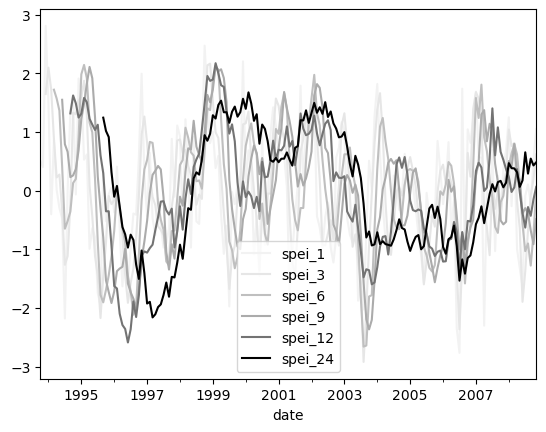

In [75]:
colors = ["0.95", "0.9", "0.75", "0.67", "0.45", "0"]
df_m_spei.loc[:, df_m_spei.columns.str.contains("spei")].dropna(how="all").plot(color=colors)

In [76]:
spei_timeframe_m = 6
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spei, f"spei_{spei_timeframe_m}", "severe_drought"))
events_df.sort_values(f"severe_drought_spei_{spei_timeframe_m}_magnitude", ascending=False)

,severe_drought_spei_6_first_start_idx,severe_drought_spei_6_last_start_idx,severe_drought_spei_6_magnitude,severe_drought_spei_6_duration
2,2003-07-01,2003-11-01,10.71,5
1,1996-07-01,1996-09-01,5.81,3
0,1995-08-01,1995-10-01,5.37,3
3,2006-09-01,2006-09-01,1.58,1


In [77]:
# TODO: Run SPEI workflow for The Bilt!
# Goal: find out if droughts and/or extreme wetness are becoming more intense recently

In [2]:
import copy
import datetime
import numpy as np
import pandas as pd
import scipy.stats as scs

In [3]:
import knmi_meteo_ingest
import knmi_meteo_transform

import knmi_spi_utils
import mice_imputation_utils

In [70]:
import importlib
importlib.reload(knmi_spi_utils)

<module 'knmi_spi_utils' from '/Users/tomrooijakkers/Projecten/Data Science Portfolio/data-science-portfolio/knmi-weather/knmi_spi_utils.py'>

In [61]:
BILT_STN_CODE = 260

In [62]:
df_rain = knmi_spi_utils.get_measured_stn_precip_values(stn_code=BILT_STN_CODE,
                                                        param_col="rain_sum")
df_evap = knmi_spi_utils.get_measured_stn_precip_values(stn_code=BILT_STN_CODE,
                                                        param_col="evap_ref")

In [71]:
# Run imputation workflow
df_rain_sel = knmi_spi_utils.imputation_workflow(df_rain, "rain_sum", BILT_STN_CODE,
                                                 print_progress = False)
df_evap_sel = knmi_spi_utils.imputation_workflow(df_evap, "evap_ref", BILT_STN_CODE,
                                                 print_progress = True)

No matching stations found for MICE imputation; use another method or drop missing data instead of imputing.


In [72]:
df_evap_sel

,date,evap_ref,is_imputed
0,1957-07-01,3.6,False
1,1957-07-02,4.2,False
2,1957-07-03,3.3,False
3,1957-07-04,3.8,False
4,1957-07-05,3.7,False
...,...,...,...
24651,2024-12-27,0.2,False
24652,2024-12-28,0.1,False
24653,2024-12-29,0.1,False
24654,2024-12-30,0.1,False


In [73]:
df_pcp_sel = knmi_spi_utils.calc_rain_min_evap_df(df_rain_sel, df_evap_sel)

In [74]:
df_m_spei = (knmi_spi_utils
             .calculate_nmonth_spei(df_pcp_sel, "rain_min_evap"))

In [75]:
df_m_spei

,rain_min_evap,is_imputed,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24
date,,,,,,,,
1906-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-01,-56.275,0.0,-1.373967,-1.413389,-0.713511,0.696289,2.106480,1.590319
2024-09-01,97.150,0.0,1.284063,-0.297969,-0.321785,0.510309,2.676583,1.754363
2024-10-01,12.650,0.0,-0.115390,-0.099340,-0.418360,0.094064,1.740964,1.780069


<Axes: xlabel='date'>

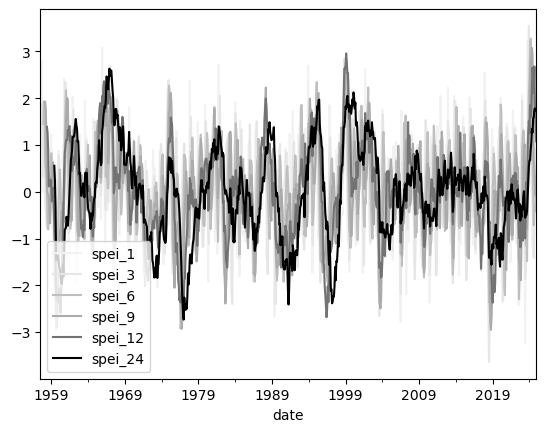

In [76]:
colors = ["0.95", "0.9", "0.75", "0.67", "0.45", "0"]
df_m_spei.loc[:, df_m_spei.columns.str.contains("spei")].dropna(how="all").plot(color=colors)

In [86]:
spei_timeframe_m = 6
events_df = (knmi_spi_utils
             .get_events_from_z_scores(df_m_spei, f"spei_{spei_timeframe_m}", "wetness"))
events_df.sort_values(f"wetness_spei_{spei_timeframe_m}_magnitude", ascending=False)

,wetness_spei_6_first_start_idx,wetness_spei_6_last_start_idx,wetness_spei_6_magnitude,wetness_spei_6_duration
43,2023-12-01,2024-05-01,14.69,6
24,1998-10-01,1999-04-01,14.29,7
9,1974-11-01,1975-04-01,10.41,6
5,1965-12-01,1966-05-01,9.67,6
21,1993-12-01,1994-05-01,8.71,6
1,1960-12-01,1961-04-01,8.65,5
22,1995-01-01,1995-05-01,8.64,5
6,1966-11-01,1967-04-01,8.48,6
27,2001-12-01,2002-04-01,7.53,5
38,2017-12-01,2018-04-01,6.86,5


In [97]:
df_m_spei_pivot = df_m_spei.copy()

keep_cols = df_m_spei_pivot.columns.str.contains("spei")
df_m_spei_pivot = df_m_spei_pivot.loc[:, keep_cols].dropna(how="all")

df_m_spei_pivot["month"] = df_m_spei_pivot.index.month
df_m_spei_pivot["year"] = df_m_spei_pivot.index.year

In [281]:
df_m_spei_pivot

,spei_1,spei_3,spei_6,spei_9,spei_12,spei_24,month,year
date,,,,,,,,
1957-07-01,-0.000430,NaN,NaN,NaN,NaN,NaN,7,1957
1957-08-01,1.146221,NaN,NaN,NaN,NaN,NaN,8,1957
1957-09-01,2.792563,1.783387,NaN,NaN,NaN,NaN,9,1957
1957-10-01,0.182129,1.876742,NaN,NaN,NaN,NaN,10,1957
1957-11-01,-0.019732,1.298980,NaN,NaN,NaN,NaN,11,1957
...,...,...,...,...,...,...,...,...
2024-08-01,-1.373967,-1.413389,-0.713511,0.696289,2.106480,1.590319,8,2024
2024-09-01,1.284063,-0.297969,-0.321785,0.510309,2.676583,1.754363,9,2024
2024-10-01,-0.115390,-0.099340,-0.418360,0.094064,1.740964,1.780069,10,2024


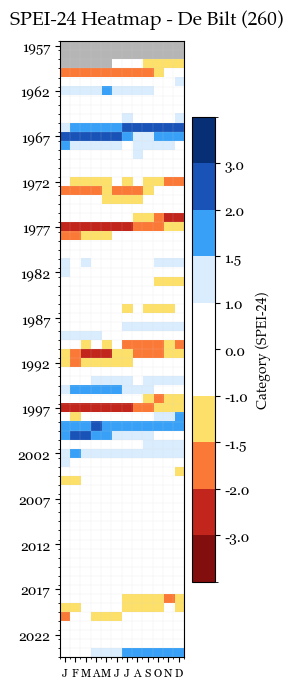

In [ ]:
%matplotlib inline

ax = (knmi_meteo_visualize
      .standardized_index_heatmap(df_m_spei_pivot, "spei_24", 
                                  f"De Bilt ({BILT_STN_CODE})"))

# Show the plot
plt.show()

In [78]:
# TODO: Mention existence of SPI/SPEI package for Python: https://github.com/e-baumer/standard_precip

In [ ]:
# TODO: Mention where SPI / SPEI results could be used; e.g.: drought monitoring / warning system; Machine Learning 
# (standardized, so great for feature engineering!)